In [1]:
import pandas as pd
import numpy as np
import pickle
missing_values = ["n/a", "na", "--", " "]
train_df = pd.read_csv("/home/cardosoo/492_19summer/MachineLearning/Data/Level 2 Post-Interaction predicting Actor, Sample B.csv", na_values = missing_values )
test_df = pd.read_csv("/home/cardosoo/492_19summer/MachineLearning/Data/Level 2 Post-Interaction predicting Actor, Sample B.csv" , na_values = missing_values )



number of missing data

In [2]:
train_df.isna().sum().sum(),test_df.isna().sum().sum()

(25, 25)

Filling missing Data with 0

In [3]:
train = train_df.fillna(0)
test = test_df.fillna(0)
train.isna().sum().sum(),test.isna().sum().sum()

(0, 0)

Let's see what intersects

In [4]:
# columns may have same names but different cases
train_cols = [x.lower() for x in train.columns.tolist()] 
test_cols = [x.lower() for x in test.columns.tolist()]
print(len(train_cols))
print(len(test_cols))
A = set(train_cols)
B = set(test_cols)
C = A & B
C = A & B

len(C)

42
42


42

In [5]:
print("Non intersecting column names: "+str(A-C)+"")
print(A - C)
print( B-C)
D = A - C
E = B - C
Not_C = D | E
for x in Not_C:
    if x in train_cols:
        train_cols.remove(x)
    if x in test_cols:
        test_cols.remove(x)
print(len(train_cols),len(test_cols))

train_X = train_cols[0:len(train_cols)-1]# not including digging actor
y = train_cols[len(train_cols)-1]
test_X = test_cols[0:len(test_cols)-1]
train_X.sort()
test_X.sort()
train_X.append(y)
test_X.append(y) 
print(train_X == test_X)

train_cols = train.columns.tolist() 
test_cols = test.columns.tolist()
# making the column names lowercase so we can index the features we want
train_cols = [x.lower() for x in train_cols]
test_cols = [x.lower() for x in test_cols]

#reassigning column names
train.columns = train_cols
test.columns = test_cols


Non intersecting column names: set()
set()
set()
42 42
True


In [6]:
#for i,j in zip(train_cols,train_X):
    #print(i,j)
len(train_cols), len(train_X )

(42, 42)

In [7]:
len(train_X), len(test_X )
train = train[train_X]
test = test[test_X]
train_data = train.values.astype('float')
test_data = test.values.astype('float')
cols = train_data.shape[1]


# Joining sample A and sample B together
full_data = np.concatenate((train_data,test_data))
full_data.shape,train_data.shape,test_data.shape

y = full_data[:,cols-1]
X = full_data[:,0:cols-1]
X.shape, y.shape

((374, 41), (374,))

# Helper functions

In [8]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import layers
from keras import models
"""
Builds a nn regression modelall_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories
"""
def build_model(units,layerz,metric,shape):
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu', 
                           input_shape = (shape,)))
    for layer in range(layerz):
        model.add(layers.Dense(units, activation = 'relu'))
    model.add(layers.Dense(1)) #linear layer
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics =[metric] )
    return model

"""
params: units, layerz, metric,num_epochs
returns : mae, loss, validation loss and validition mae histories for each fold
          tuple( all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories)
"""
def validaton(hyper_parameters,shape,data):
    k = 4
    
    units, layerz = hyper_parameters['units'], hyper_parameters['layerz']
    metric,num_epochs = hyper_parameters['metric'], hyper_parameters['num_epochs']
    train_data,train_targets = data['train'],data['target']
    
    num_val_samples = len(train_data) // k
    all_val_mae_histories = []
    all_val_loss_histories = []
    all_loss_histories = []
    all_mae_histories = []
    
    print("val_samples: " + str(num_val_samples))
    for i in range(k):
        print('\tprocessing fold #', i)
        start = i*num_val_samples
        stop = (i + 1) * num_val_samples
        val_data = train_data[start:stop]
        val_target = train_targets[start:stop]

        partial_train_data = np.concatenate( (train_data[:start], train_data[stop:]) ,axis = 0)
        partial_train_target = np.concatenate( (train_targets[:start],train_targets[stop:]), axis = 0) 

        model = build_model(units, layerz, metric,shape)
        history = model.fit(partial_train_data, partial_train_target, epochs = num_epochs, batch_size = 1, verbose = 0,
                            validation_data = (val_data, val_target) )


        val_mae_history = history.history['val_mean_absolute_error']
        val_loss_history = history.history['val_loss']
        loss_history = history.history['loss']
        mae_history = history.history['mean_absolute_error']

        all_val_mae_histories.append(val_mae_history)  
        all_val_loss_histories.append(val_loss_history)
        all_loss_histories.append(loss_history)
        all_mae_histories.append(mae_history)

    return all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories

"""
returns the histories of all the P * K folds
"""
def iterated_validation(num_iterations,hyper_parameters,shape,data):
    all_val_mae_histories = []
    all_val_loss_histories = []
    all_loss_histories = []
    all_mae_histories = []
    train_data,train_targets = data['train'],data['target']
    for i in range(num_iterations):
        print("iteration: "+str(i+1))
            # shuffle training data
        rows = np.arange(train_targets.size)
        indexes = shuffle(rows)
        train_data = train_data[indexes]
        train_targets = train_targets[indexes]
        print("\tStarting indexes for training " +str(indexes[0:5]))
        
        histories = validaton(hyper_parameters,shape,data)
        all_val_mae_histories.extend(histories[0])
        all_val_loss_histories.extend(histories[1])
        all_loss_histories.extend(histories[2])
        all_mae_histories.extend(histories[3])
        
    return all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories

"""
Returns the mean for each elements returned in by the 
iterated_validation or validation function
"""
def average_folds(all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories):
    averages = []
    num_epochs = len(all_val_mae_histories[0])
    averages.append([np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)])
    averages.append([np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)])
    averages.append([np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)])
    averages.append([np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)])
    
    return averages

"""
Creates and plots 4 subplots. That represents 
the loss and Mae for the training and validation set
"""
def plots(histories):
    epoch = range(1,len(histories[0])+1) 
    f, axes = plt.subplots(2, 2, figsize=(12,12))
    axes = axes.reshape((4,))
    for i,average in enumerate(histories):
        if i % 2 == 0:
            axes[i].plot(epoch,average, label='Training')
        else:
            axes[i].plot(epoch,average, 'r', label='Validation')
        axes[i].legend()
        axes[i].set_xlabel("Epoch")
    axes[0].set_ylabel("MAE")

    axes[2].set_ylabel("Loss")
    
def plot_features(features, names, smooth=0):
    val_mae_index = 1
    val_loss_index = 3
    epochs = range(1,len(features[names[0]][val_mae_index])+1)
    color = ["b","r","g","k"]
    plt.figure(figsize=(12,12))
    plt.title('overfitting with different size features')
    plt.xlabel('Epochs')
    plt.ylabel('Validation mae')
    for i,name in enumerate(names):
        if smooth != 0:
            plt.plot(epochs, smooth_curve(features[names[i]][val_mae_index]), color[i], label=name) 
        else:
            plt.plot(epochs, features[names[i]][val_mae_index], color[i], label=name) 
        plt.legend()
        print(name + " had a " + str(np.min(features[names[i]][val_mae_index])) +" MAE value")
        print(name + " had a " + str(np.min(features[names[i]][val_loss_index])) +" Loss value")
        print()
    plt.show()
    

    
"""
Manipulates the data such that it looks smoother when you plot it
"""
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point*(1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# types of features selections criteria i used

criteria = ["CR", "MI","DI","DA"] 
"""

"""
def bestKFeautues(criteria,K,train_datas, train_target):
    features = {}
    for i in range(len(criteria)):
        print("\t\t\t\t\t\t\t "+str(criteria[i]))
        hyper_parameters = dict(units = 32, layerz = 2, metric ='mae', num_epochs = 100)
        shape = K
        data = dict(train= train_datas[i], target = train_target)
        all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories = iterated_validation(1, hyper_parameters,shape,data)

        # find the averages
        averages = average_folds(all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories)
        #import pdb; pdb.set_trace()
        # set appriopriate feature criteria to averages
        features[criteria[i]] = (averages[0], averages[1], averages[2],averages[3])
    return features

def normalize(X, indices):
    normalized_train_datas = []
    normalized_test_datas = []
    mean = X[0:300,:].mean(axis = 0)
    normalized_X = X.copy()
    normalized_X[0:300,:] -= mean
    std = X.std(axis = 0)
    normalized_X /= std

    for i in range(len(indices)): # should change this the test_data has information about the whole dataset
        normalized_train_datas.append(normalized_X[0:300,indices[i]])
        normalized_test_datas.append(normalized_X[300:,indices[i]])
    return normalized_train_datas

Using TensorFlow backend.


# Feature selection


In [9]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression,f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
cols = full_data.shape[1]# == train_data,test_data

y = full_data[:,cols-1]
X = full_data[:,0:cols-1]



def Indices(num,X,y):
    #correlation
    selector = SelectKBest(f_regression, k=num).fit(X,y)
    indices1 = selector.get_support(indices=True)
    index = range(X.shape[1])

    #mutual information

    selector = SelectKBest(mutual_info_regression, k=num).fit(X,y)
    indices2 = selector.get_support(indices=True)
    indices2

    #Mean decrease impurity

    #Load boston housing dataset as an example
    rf = RandomForestRegressor(criterion = "mae",n_estimators = 100)
    rf.fit(X, y)

    
    scores_impurity = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_),index), 
                 reverse=True)
    indices3 = list(map(lambda x: x[1] ,scores_impurity[0:num]))
    #print(indices3)

    #Mean decrease accuracy

    
    rf = RandomForestRegressor()
    scores = defaultdict(list)

    #crossvalidate the scores on a number of different random splits of the data
    for i in range(100):
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        r = rf.fit(X_train, Y_train)
        acc = r2_score(Y_test, rf.predict(X_test))
        for i in range(X.shape[1]):
            X_t = X_test.copy()
            np.random.shuffle(X_t[:, i])
            shuff_acc = r2_score(Y_test, rf.predict(X_t))
            scores[index[i]].append((acc-shuff_acc)/acc)
    #print("Indices determined by Mean decrease accuracy")
    #print("Features sorted by their score:")
    scores_accuracy = sorted([(round(np.mean(score), 4), i) for
                  i, score in scores.items()], reverse=True)
    indices4 = list(map(lambda x: x[1] ,scores_accuracy[0:num]))
    #print(indices4)
    return [indices1,indices2,indices3,indices4]


In [12]:
indices[0]

array([ 0,  2, 31, 33, 35, 36, 37, 38, 39, 40])

In [14]:
[train_X[i] for i in indices[0]]

['chemisactorgm',
 'dominactorgm',
 'intellactorgm',
 'pdiggingactorgm',
 'percpopactorgm',
 'physhotactorgm',
 'psanxactorgm',
 'psavoidactorgm',
 'vitalityactorgm',
 'warmthactorgm']

# Experiment 1:
units = 24, layerz = 2

k = 10

In [11]:
import pickle
pickle_out = open("Best 10 Post features in Actor","wb")
num = 10 #num of selected features
indices = Indices(num,X,y)

pickle.dump(indices,pickle_out)
pickle_out.close()


/home/cardosoo/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [11]:
num = 20 #num of selected features
indices = Indices(num,X,y)
pickle_out = open("Best 20 Post features in Actor","wb")
pickle.dump(indices,pickle_out)
pickle_out.close()

/home/cardosoo/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
num = 10 #num of selected features
indices = Indices(num,X,y)
#corrolation, Mutual Information, Mean decrease impurities ,Mean decrease accuracy
train_datas = []
test_datas = []
for i in range(len(indices)):
    train_datas.append(X[0:300,indices[i]])
    test_datas.append(X[300:,indices[i]])
    
train_target = y[0:300]
test_target = y[300:]

/home/cardosoo/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
features = bestKFeautues(criteria,num,train_datas, train_target )

							 CR
iteration: 1
	Starting indexes for training [ 32 134 294  17  49]
val_samples: 75
	processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 MI
iteration: 1
	Starting indexes for training [ 37 101  28 226 168]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DI
iteration: 1
	Starting indexes for training [244  89 192 181 269]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DA
iteration: 1
	Starting indexes for training [234  57 214 129  60]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3


In [14]:
#note your loss and accuracy graphs may look different because of initial randomizaiton
pickle_out = open("Experiment1", "wb")
pickle.dump(features,pickle_out)
pickle_out.close()

CR had a 0.18655854022751253 MAE value
CR had a 0.09388591566205222 Loss value

MI had a 0.19068222027271986 MAE value
MI had a 0.09836036069370303 Loss value

DI had a 0.17443794433648388 MAE value
DI had a 0.07838215274181382 Loss value

DA had a 0.18745146812560656 MAE value
DA had a 0.08661246817805472 Loss value



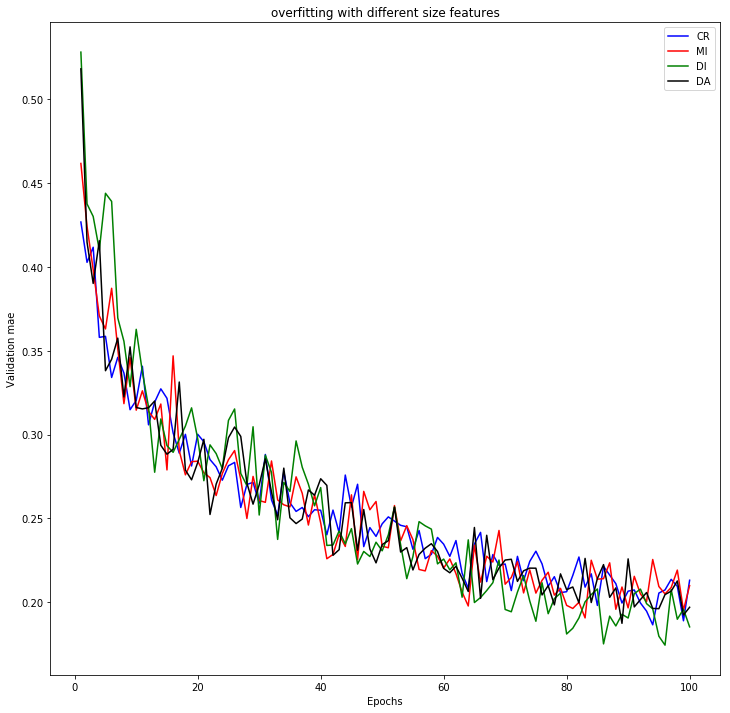

In [15]:
plot_features(features, criteria)

# Smooth curve

CR had a 0.18655854022751253 MAE value
CR had a 0.09388591566205222 Loss value

MI had a 0.19068222027271986 MAE value
MI had a 0.09836036069370303 Loss value

DI had a 0.17443794433648388 MAE value
DI had a 0.07838215274181382 Loss value

DA had a 0.18745146812560656 MAE value
DA had a 0.08661246817805472 Loss value



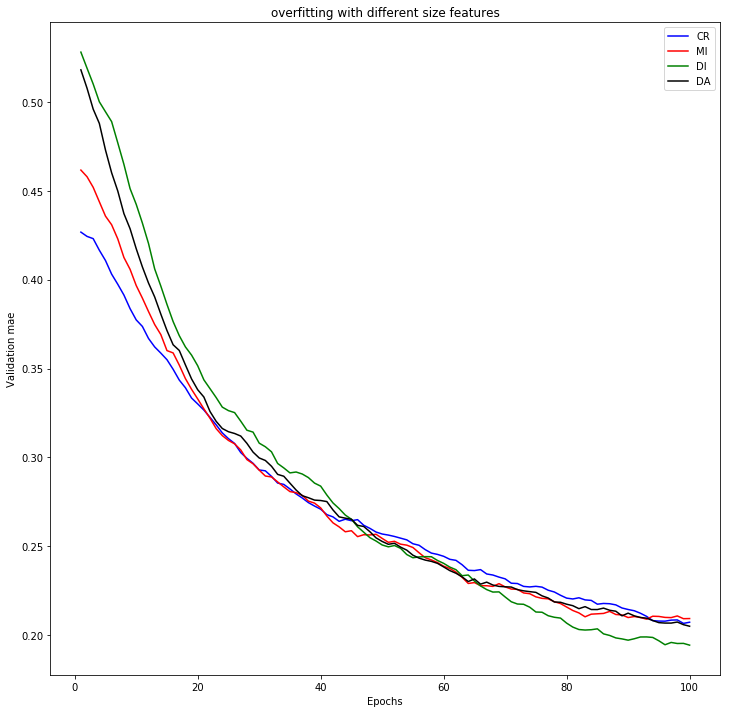

In [16]:
plot_features(features, criteria,1)

# Experiment 2
units = 24, layerz = 2

k = 10
normalized values

In [17]:

normalized_train_datas = []
normalized_test_datas = []
mean = X[0:300,:].mean(axis = 0)
normalized_X = X.copy()
normalized_X[0:300,:] -= mean
std = X.std(axis = 0)
normalized_X /= std

for i in range(len(indices)): # should change this the test_data has information about the whole dataset
    normalized_train_datas.append(normalized_X[0:300,indices[i]])
    normalized_test_datas.append(normalized_X[300:,indices[i]])
len(normalized_train_datas)

4

In [18]:
features_normalize10 = bestKFeautues(criteria,num,normalized_train_datas, train_target )


							 CR
iteration: 1
	Starting indexes for training [231 122  47 147  98]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 MI
iteration: 1
	Starting indexes for training [218 233 192  65 232]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DI
iteration: 1
	Starting indexes for training [127 252  37  67 186]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DA
iteration: 1
	Starting indexes for training [133 269 239 265 266]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3


In [19]:
pickle_out = open("Experiment2", "wb")
pickle.dump(features_normalize10,pickle_out)
pickle_out.close()

CR had a 0.14173011836906274 MAE value
CR had a 0.06285954908919622 Loss value

MI had a 0.15417983951667943 MAE value
MI had a 0.07735355472292155 Loss value

DI had a 0.13169760061427951 MAE value
DI had a 0.05411990692013955 Loss value

DA had a 0.14871810980762043 MAE value
DA had a 0.06897617815522446 Loss value



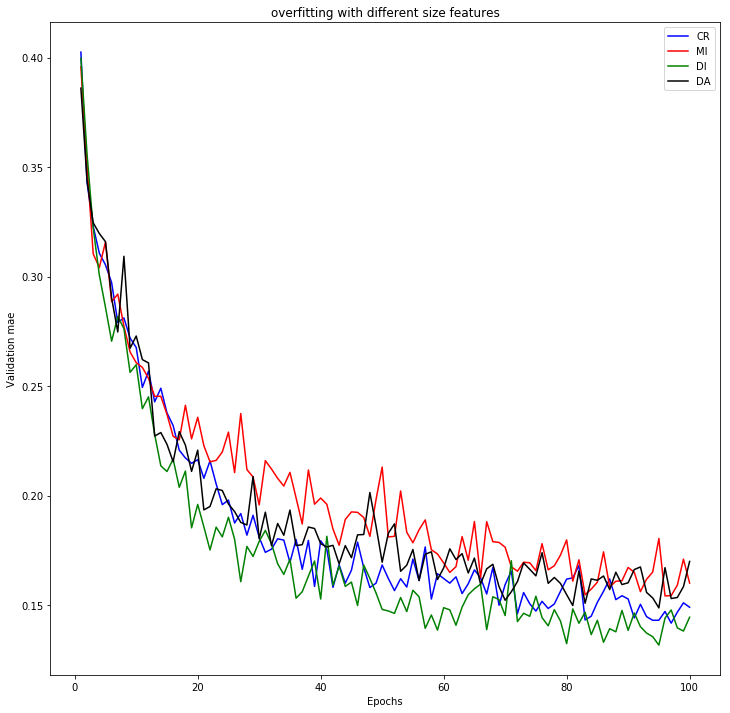

In [20]:
plot_features(features_normalize10,criteria)

# Smooth

CR had a 0.14173011836906274 MAE value
CR had a 0.06285954908919622 Loss value

MI had a 0.15417983951667943 MAE value
MI had a 0.07735355472292155 Loss value

DI had a 0.13169760061427951 MAE value
DI had a 0.05411990692013955 Loss value

DA had a 0.14871810980762043 MAE value
DA had a 0.06897617815522446 Loss value



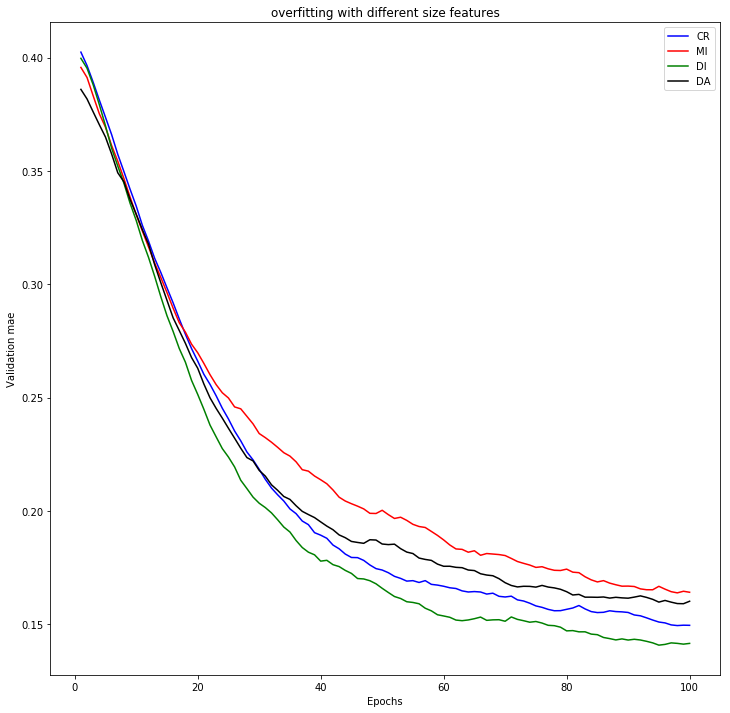

In [21]:
plot_features(features_normalize10,criteria,1)

# Experiment 3
units = 24, layerz = 2 
k = 20
normalized values

/home/cardosoo/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


							 CR
iteration: 1
	Starting indexes for training [198 234 162 241  29]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 MI
iteration: 1
	Starting indexes for training [149 124   7 270 129]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DI
iteration: 1
	Starting indexes for training [202  52 288 287 215]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DA
iteration: 1
	Starting indexes for training [216 256 165 277 172]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
CR had a 0.13614690456539394 MAE value
CR had a 0.06800117433568 Loss value

MI had a 0.15170082049444317 MAE value
MI had a 0.0728990384227607 Loss value

DI had a 0.1375558614047865 MAE value
DI had a 0.06392325630517473 Loss value

DA had a 0.1353406252230828 MAE value
DA had a 0.05652081

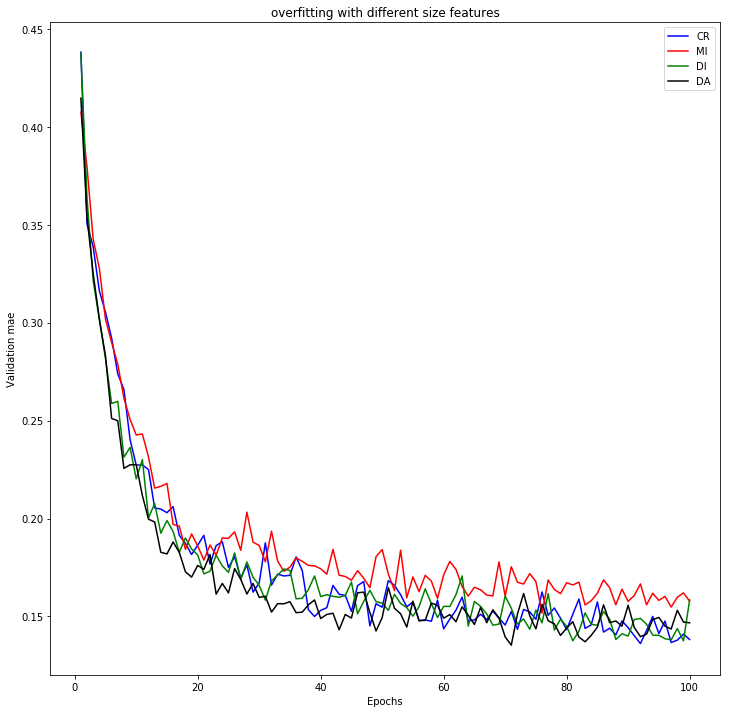

In [22]:
num = 20 #num of selected features
indices = Indices(num,X,y)

normalized_train_datas = []
normalized_test_datas = []
mean = X[0:300,:].mean(axis = 0)
normalized_X = X.copy()
normalized_X[0:300,:] -= mean
std = X.std(axis = 0)
normalized_X /= std

for i in range(len(indices)): # should change this the test_data has information about the whole dataset
    normalized_train_datas.append(normalized_X[0:300,indices[i]])
    normalized_test_datas.append(normalized_X[300:,indices[i]])
len(normalized_train_datas)
features_normalize20 = bestKFeautues(criteria,num,normalized_train_datas, train_target )
plot_features(features_normalize20,criteria)

In [23]:
pickle_out = open("Experiment3", "wb")
pickle.dump(features_normalize20,pickle_out)
pickle_out.close()

CR had a 0.13614690456539394 MAE value
CR had a 0.06800117433568 Loss value

MI had a 0.15170082049444317 MAE value
MI had a 0.0728990384227607 Loss value

DI had a 0.1375558614047865 MAE value
DI had a 0.06392325630517473 Loss value

DA had a 0.1353406252230828 MAE value
DA had a 0.05652081425311889 Loss value



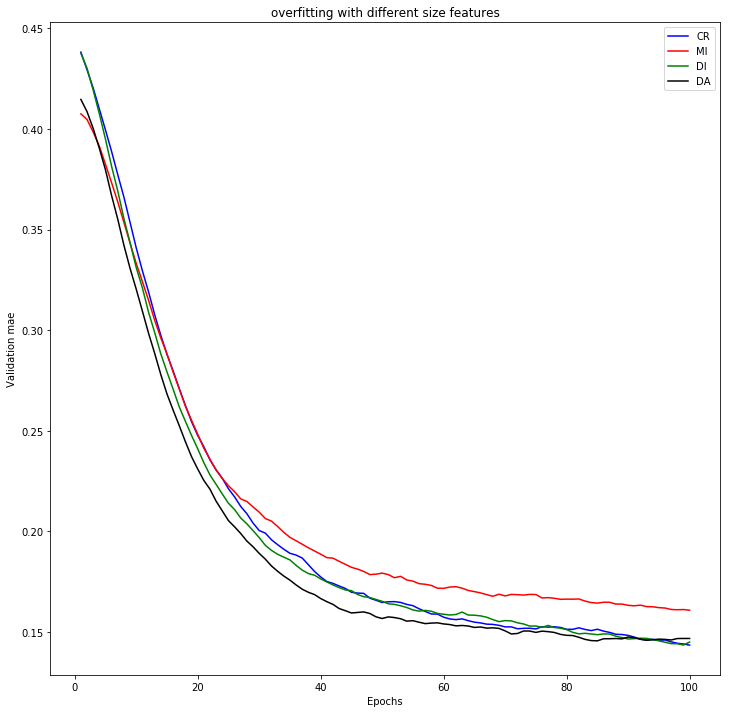

In [24]:
pickle_in = open("Experiment3","rb")
features_normalize20 = pickle.load(pickle_in)

plot_features(features_normalize20, criteria, 1)

# Experiment 4
units = 24, layerz = 2 
k = 30
normalized values


/home/cardosoo/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


							 CR
iteration: 1
	Starting indexes for training [260 265 217 125 249]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 MI
iteration: 1
	Starting indexes for training [ 41 271 279 234 219]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DI
iteration: 1
	Starting indexes for training [274 114 139 213 111]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DA
iteration: 1
	Starting indexes for training [137 160 117   5 182]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
CR had a 0.1397309119316439 MAE value
CR had a 0.06629587014980785 Loss value

MI had a 0.12724513601511717 MAE value
MI had a 0.05654588800151378 Loss value

DI had a 0.14679712063943345 MAE value
DI had a 0.06525017639428939 Loss value

DA had a 0.13830909768119454 MAE value
DA had a 0.064

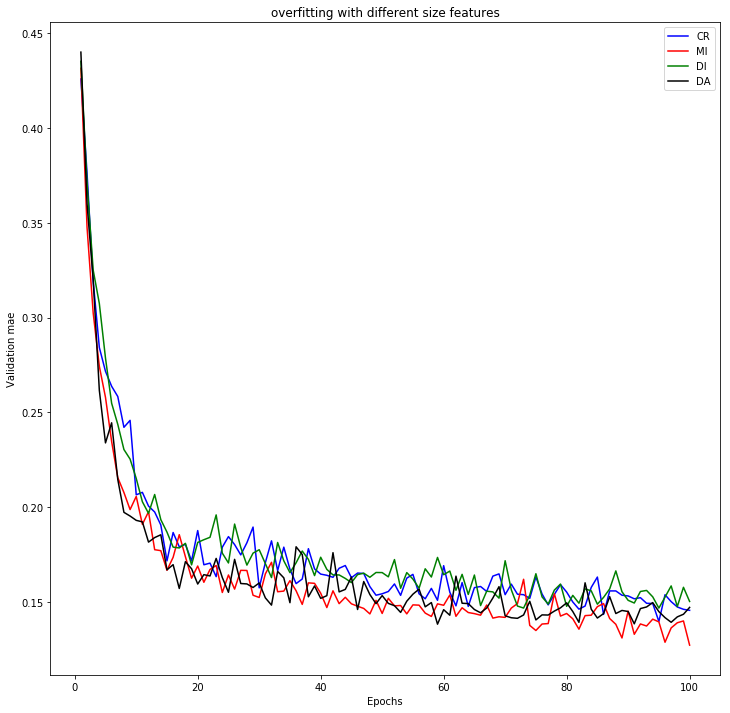

In [25]:
num = 30 #num of selected features
indices = Indices(num,X,y)
normalized_train_datas = normalize(X,indices)
features_normalize30 = bestKFeautues(criteria,num,normalized_train_datas, train_target )
plot_features(features_normalize30,criteria)

In [26]:
pickle_out = open("Experiment4", "wb")
pickle.dump(features_normalize30,pickle_out)
pickle_out.close()

# Experiment 5
units = 24, layerz = 2 
k = 40
normalized values


/home/cardosoo/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


							 CR
iteration: 1
	Starting indexes for training [134  81  10  33  47]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 MI
iteration: 1
	Starting indexes for training [ 41 159 193  54 114]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DI
iteration: 1
	Starting indexes for training [209 186 225 226  38]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
							 DA
iteration: 1
	Starting indexes for training [232 281  61 230 220]
val_samples: 75
	processing fold # 0
	processing fold # 1
	processing fold # 2
	processing fold # 3
CR had a 0.14982474909474452 MAE value
CR had a 0.08079676532879726 Loss value

MI had a 0.14326672005156674 MAE value
MI had a 0.06427083157419881 Loss value

DI had a 0.14471776803955436 MAE value
DI had a 0.07754912484547441 Loss value

DA had a 0.13700608633458614 MAE value
DA had a 0.06

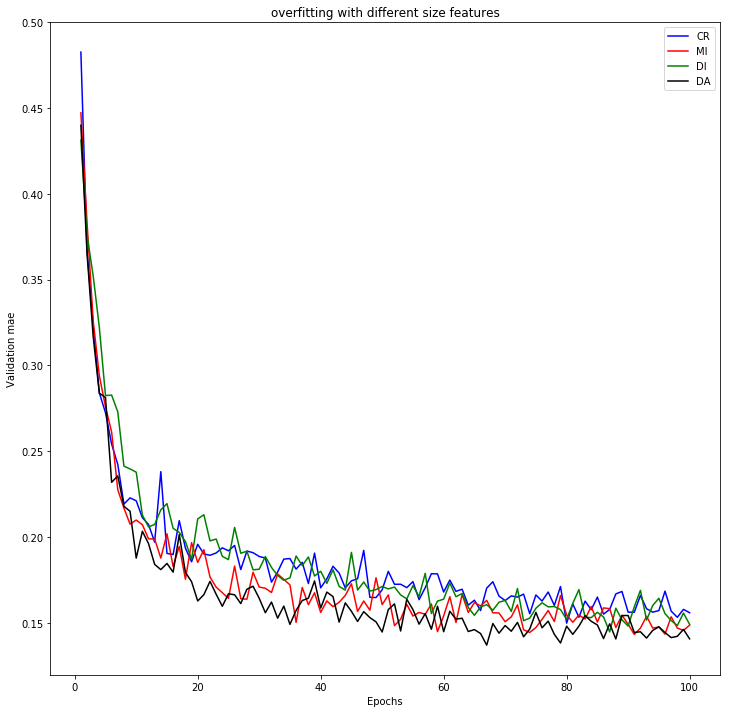

In [27]:
num = 40 #num of selected features

indices = Indices(num,X,y)
normalized_train_datas = normalize(X,indices)
features_normalize40 = bestKFeautues(criteria,num,normalized_train_datas, train_target )
plot_features(features_normalize40,criteria)

In [28]:
import pickle
pickle_out = open("Experiment5", "wb")
pickle.dump(features_normalize40,pickle_out)
pickle_out.close()

CR had a 0.14982474909474452 MAE value
CR had a 0.08079676532879726 Loss value

MI had a 0.14326672005156674 MAE value
MI had a 0.06427083157419881 Loss value

DI had a 0.14471776803955436 MAE value
DI had a 0.07754912484547441 Loss value

DA had a 0.13700608633458614 MAE value
DA had a 0.062254641304818 Loss value



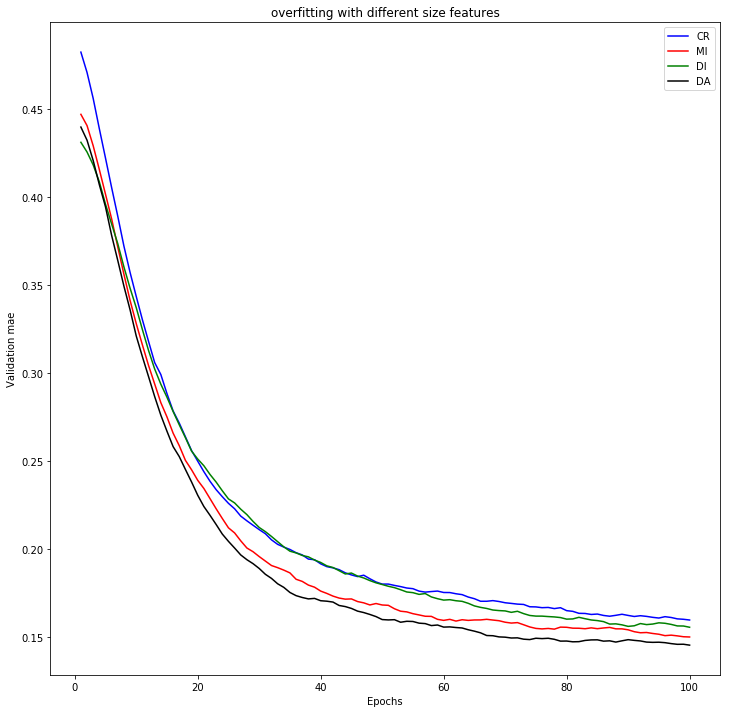

In [29]:
pickle_in = open("Experiment5","rb")
features_normalize40 = pickle.load(pickle_in)
plot_features(features_normalize40, criteria, 1)